In [1]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
import scipy.signal as signal
import numpy as np

from IPython.display import Audio, display, HTML
from ipywidgets import interact

from scipy.io import wavfile
import requests
from io import BytesIO

%matplotlib inline
matplotlib.rcParams['animation.writer'] = 'avconv'
matplotlib.rcParams['figure.figsize'] = "8,3"

# workaround function for strange interact implementation
def showInInteract():
    import inspect
    for i in range(5):
        if 'interaction.py' in inspect.stack()[i][1]: plt.show()

In [2]:
def fourierSeries(period, N):
    """Calculate the Fourier series coefficients up to the Nth harmonic"""
    result = []
    T = len(period)
    t = np.arange(T)
    for n in range(N+1):
        an = 2/T*(period * np.cos(2*np.pi*n*t/T)).sum()
        bn = 2/T*(period * np.sin(2*np.pi*n*t/T)).sum()
        result.append((an, bn))
    return np.array(result)

In [3]:
def reconstruct(P, anbn):
    """Sum up sines and cosines according to the coefficients to 
    produce a reconstruction of the original waveform"""
    result = 0
    t = np.arange(P)
    for n, (a, b) in enumerate(anbn):
        if n == 0:
            a = a/2
        result = result + a*np.cos(2*np.pi*n*t/P) + b * np.sin(2*np.pi*n*t/P)
    return result

In [5]:
def loadSound(url):
    R = requests.get(url)
    rate, data = wavfile.read(BytesIO(R.content))
    data = data * 1.0 / (abs(data).max())
    if len(data.shape) > 1:  # for stereo data, use only first channel
        data = data[:,0]
    return data, rate

# the URLs of the wav files
urls = [
       "http://cd.textfiles.com/sbsw/INSTRMNT/TENORSA.WAV"]
sounds = []

for url in urls:
    sound, rate = loadSound(url)
    sounds.append((sound, rate))

In [6]:
# Utility function two display two audios side by side in the notebook
def audioSideBySide(name1, audio1, name2, audio2):
    text = '<table class="audiotable"><tr><td>%s</td><td>%s</td></tr><tr><td>%s</td><td>%s</td></tr></table>' % (name1, name2, audio1._repr_html_(), audio2._repr_html_())
    display(HTML(text))

In [7]:
for n, s in enumerate(sounds):
    display(HTML("<div>Saxophone sound %d</div>" % (n+1) + Audio(data=s[0], rate=s[1])._repr_html_()))

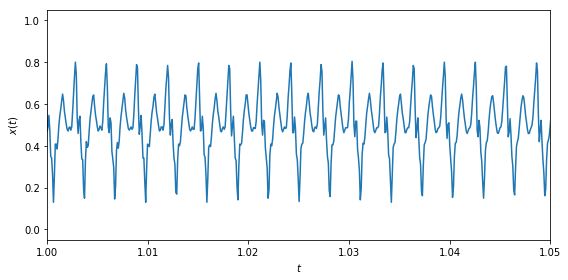

In [9]:
t = np.arange(len(sounds[0][0])) / sounds[0][1]
plt.figure(figsize=(8,4))
plt.plot(t, sounds[0][0])
plt.xlim((1, 1.05))
plt.xlabel('$t$'); plt.ylabel('$x(t)$')
plt.tight_layout()

[0.11764706 0.38039216 0.14901961 ... 0.50196078 0.47058824 0.45098039] 11025
0.8005 oi
0.8034 eta


Original,Extracted period


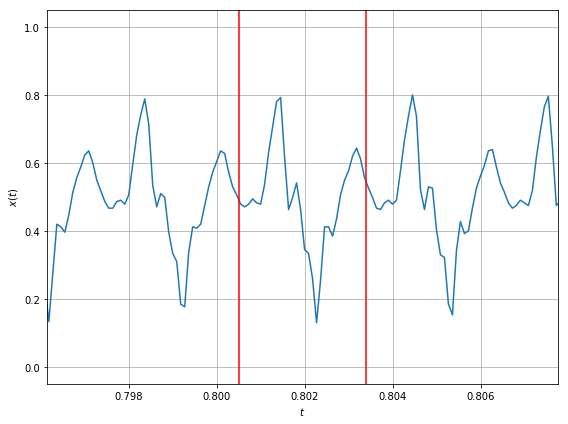

In [27]:
def extractPeriod(data, rate, t_start, t_end):
    t = np.arange(0,len(data))/rate
    plt.plot(t, data)
    print(data, rate)
    duration = t_end - t_start
    print(t_start, 'oi')
    print(t_end, 'eta')
    plt.xlim((t_start-1.5*duration, t_end+1.5*duration))
    plt.grid(True)
    plt.xlabel('$t$'); plt.ylabel('$x(t)$');

    plt.axvline(t_start, color='red')
    plt.axvline(t_end, color='red')

    sample_start = int(t_start * rate)
    sample_end = int(t_end*rate)

    period = data[sample_start:sample_end]
    audioSideBySide("Original", Audio(data=data,rate=rate), 
                    "Extracted period", Audio(np.tile(period, int(1/duration)), rate=rate))
    return period, rate

plt.figure(figsize=(8,6))
periods = []
rates = []
# The manually found start and end time of one period of the signal
periodBounds = [(0.8005,0.8034),
                (0.8044,0.8075),
                (0.20555,0.2132)]
for n, (S, P) in enumerate(zip(sounds, periodBounds)):
    plt.subplot(len(sounds), 1, n+1)
    period, rate = extractPeriod(S[0], S[1], P[0], P[1])
    periods.append(period); rates.append(rate)
plt.tight_layout()

In [13]:
def approximateUpToNthHarmonic(period, rate, N):
    t = np.arange(len(period)) / rate
    duration = t.max()
    F = fourierSeries(period, N)
    powers = np.sqrt(np.sum(F**2, axis=1))
    reconstructed = reconstruct(len(period), F)
    
    plt.figure(figsize=(8,2))
    plt.subplot(121)
    plt.plot(t*1000, period, label='Original') 
    plt.plot(t*1000, reconstructed, label='Reconstructed')
    plt.xlabel('$t$ [ms]'); plt.ylabel('$x(t)$'); plt.grid(True)
    plt.subplot(122)
    powers[0]=0
    plt.stem(powers)
    plt.xlim((0,20))
    plt.ylabel('Harmonic power'); plt.xlabel('Harmonic index'); plt.grid(True)
    plt.tight_layout()
    
    audioSideBySide("Original", Audio(data=np.tile(period, int(0.7/duration)), rate=rate), 
                    "Reconstructed up to %d harmonics" % N, Audio(data=np.tile(reconstructed, int(0.7/duration)), rate=rate))

Original,Reconstructed up to 1 harmonics


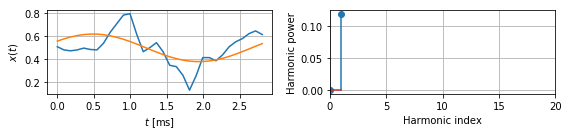

In [16]:
for P, R in zip(periods, rates):
    approximateUpToNthHarmonic(P, R, 1)

Original,Reconstructed up to 2 harmonics


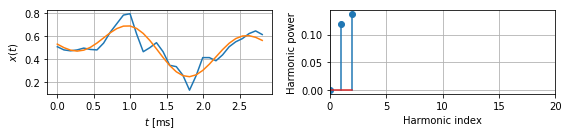

In [17]:
for P, R in zip(periods, rates):
    approximateUpToNthHarmonic(P, R, 2)

Original,Reconstructed up to 5 harmonics


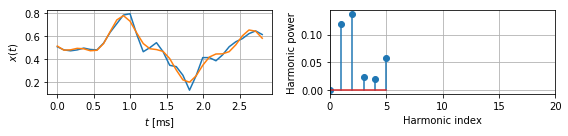

In [18]:
for P, R in zip(periods, rates):
    approximateUpToNthHarmonic(P, R, 5)

Original,Reconstructed up to 10 harmonics


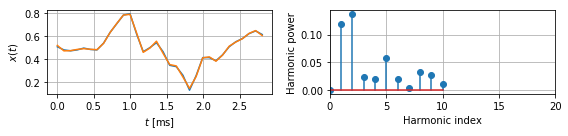

In [19]:
for P, R in zip(periods, rates):
    approximateUpToNthHarmonic(P, R, 10)

Original,Reconstructed up to 20 harmonics


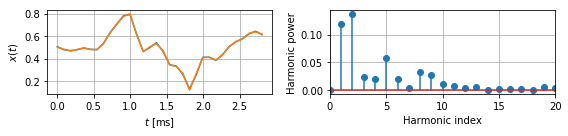

In [23]:
for P, R in list(zip(periods, rates)):
    approximateUpToNthHarmonic(P, R, 20)

In [22]:
for P, R in list(zip(periods, rates))[2:]:
    approximateUpToNthHarmonic(P, R, 30)
    plt.xlim(0,30)
    approximateUpToNthHarmonic(P, R, 40)
    plt.xlim(0,40)
    